# Aula 7 - Modelos de Aprendizado

## Aplicar Redes Bayesianas no Dataset Police

Será feito um classificador bayesiano para prever se uma parada resultará ou não em prisão.

In [2]:
import pandas as pd

In [3]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)

In [4]:
from etl.main import PoliceDatasetEtl

police_dataset_etl = PoliceDatasetEtl(df.copy())
featured_df = police_dataset_etl.clean_transform()
search_type_df = police_dataset_etl.get_search_type_df()

### Modelo Probabilístico - Rede Bayesiana

* Objetivo: Prever se uma parada policial resultará em prisão ou não
* Utilizar classificador `Bernoli Naive Bayes`, como a distribuição do `target`(ser preso ou não) segue uma distribuição binária (`Bernouli`)
* Utilizar a proporção 70% - 30% (70% treino, 30% teste)
* Utilizar validação cruzada `k-fold`

#### Notas:
* **Seleção de features:** Dado a possibilidade de reutilização de trabalhos prévios sob esse dataset, as features utilizadas serão as mesmas descobertas como sendo as que possuem melhor relação de `mutual information score` com o *target* `is_arrested`, conforme utilizado no [notebook da aula 4](./etl_aula_4.ipynb). Portanto:
    * search_type - Foi a única feature deixada como `one-hot-encoding`
    * search_conducted (foi removido uma vez que deixava a acurácia pior)
    * violation_level (foi removido uma vez que não altera a acurácia)
    * driver_race (foi removido uma vez que não altera a acurácia)
* **ETL e Feature Engineering:**
    * Está sendo utilizada a class `PoliceDatasetEtl`, desenvolvida durante as atividades anteriores. Essa classe contém métodos de limpeza, extração e engenharia da feature `violation_level` que quantifica a feature original `violation` em uma variável contínua.
* **Comparação:** Como o modelo de árvore de decisão já foi utilizado no [notebook da aula 4](./etl_aula_4.ipynb), faremos uma comparação do desempenho utilizando o modelo bayesiano para a distribuição de Bernouli.

Selecionando e adequando as features

Algumas features, incluindo o `target` deverão ser discretizados uma vez que são representadas por meio de variáveis categóricas. Para isso utilizaremos a técnica de `one hot encoder`.

In [5]:
# Please, note search type is already transformed with "one-hot-encoding" in search_type_df dataset
selected_features = [
    # "violation_level",
    # "driver_race",
]
target = "is_arrested"

training_df = featured_df[target].copy()

Aplicando `one-hot-encoder`:

In [6]:
# Fazendo o encoding das features categóricas
encoded_training_df = training_df.copy()
category_feature_to_encode = [
    # "driver_race",
]

# Fazendo o encoding da target
y_encoded = training_df.copy()
y_encoded = y_encoded.astype("category")
y_encoded = y_encoded.cat.codes

for category in category_feature_to_encode:
    encoded_training_df[category] = encoded_training_df[category].astype("category")
    encoded_training_df[f"{category}_encoded"] = encoded_training_df[category].cat.codes

# encoded_training_df.pop("driver_race")

# merge training_df with search_type_df
encoded_training_df = search_type_df.copy()

Fazendo o split do dataset para treino - teste

In [7]:
from sklearn.model_selection import train_test_split

# split training dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    encoded_training_df, y_encoded, test_size=0.3, random_state=42
)

Treinando e medindo a acurácia da `Rede Bayesiana`

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

# Inicializando o classificador Naive Bayes
naive_bayes_classifier = BernoulliNB()

# Treinando o classificador Naive Bayes com os dados de treino
naive_bayes_classifier.fit(X_train, y_train)

# Fazendo predições com o classificador Naive Bayes
y_pred_test = naive_bayes_classifier.predict(X_test)

# Medindo a acurácia do classificador Naive Bayes com os dados de teste
acuracia = accuracy_score(y_test, y_pred_test)

print(f"Acurácia: {(acuracia * 100):.2f} %")

Acurácia: 96.87 %


Utilizando validação cruzada: `K-fold`

In [9]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import BernoulliNB

training_df = search_type_df.copy()

# Realizando o encoding do target
y = featured_df.is_arrested
y_encoded = y.copy()
y_encoded = y_encoded.astype("category")
y_encoded = y_encoded.cat.codes

# split training dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    encoded_training_df, y_encoded, test_size=0.3, random_state=42
)


# Inicializando o classificador Naive Bayes
naive_bayes_classifier = BernoulliNB()

# Inicializar o KFold para obter os índices de cada fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validação cruzada com 5 folds no conjunto de treinamento
scores = cross_val_score(naive_bayes_classifier, X_train, y_train, cv=kf)

# Imprimir as pontuações de cada fold na validação cruzada
print("Cross-validation scores:", scores)

# Loop sobre os folds para obter os índices dos dados
for fold, (train_index, _) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}:")
    print(f"  - Índices dos exemplos de treinamento: {train_index}")

Cross-validation scores: [0.97119277 0.97127063 0.9687792  0.97033403 0.96854318]
Fold 1:
  - Índices dos exemplos de treinamento: [    0     1     2 ... 64215 64216 64217]
Fold 2:
  - Índices dos exemplos de treinamento: [    2     4     5 ... 64215 64216 64217]
Fold 3:
  - Índices dos exemplos de treinamento: [    0     1     2 ... 64212 64213 64214]
Fold 4:
  - Índices dos exemplos de treinamento: [    0     1     2 ... 64215 64216 64217]
Fold 5:
  - Índices dos exemplos de treinamento: [    0     1     3 ... 64215 64216 64217]


## Conclusões

* Das 4 features que pretendíamos utilizar, somente 1 (processada com `one-hot-encoding`) está sendo usada uma vez que removendo as outras features do modelo não alterava a acurácia, ou alterava positivamente.
* Utilizando o crossvalidation com o `K-fold`, podemos constatar que a acurácia com o modelo treinado em cada fold é similar, ou apresenta baixa variação. Esse fato aumenta a confiança de que o modelo irá ter performance similar em produção uma vez que a distribuição dos dados das features consideradas para o propósito é consistente em cada fold.
* Se comparado com o modelo de árvores de decisão implementado no [notebook da aula 4](./etl_aula_4.ipynb), podemos perceber uma acurácia muito similar, com baixa variação.

# Aula 8 - Métricas e Testes Estatísticos

**Obetivos:**

1. Aplicar métricas de matriz de confusão ao modelo `Bernoulli Naive Bayes` já treinado nesse notebook.
2. Utilizar árvores de decisão como modelo de classificação de comparação. Calculando também sua matriz de confusão.
3. Aplicar testes estatísticos para verificar se as diferenças entre os modelos são significativas.

In [10]:
def print_confusion_matrix(matrix):
    true_negative, false_positive, false_negative, true_positive = matrix.ravel()
    print(f"True Negative: {true_negative}")
    print(f"False Positive: {false_positive}")
    print(f"False Negative: {false_negative}")
    print(f"True Positive: {true_positive}")
    

Aplicando métricas de matriz de confusão ao modelo `Bernoulli Naive Bayes` já treinado nesse notebook.

In [11]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix

# normalize
matriz_confusao_naive_bayes = confusion_matrix(y_test, y_pred_test, normalize="true")

display("Matriz Confusão - Naive Bayes")
print_confusion_matrix(matriz_confusao_naive_bayes)

'Matriz Confusão - Naive Bayes'

True Negative: 0.9918082068239892
False Positive: 0.008191793176010822
False Negative: 0.7058177826564215
True Positive: 0.29418221734357847


Treinando uma árvore de decisão para comparação

In [12]:
# train decision tree with the same dataset
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)

# predict
y_pred_test = decision_tree_classifier.predict(X_test)

# calculate accuracy
acuracia = accuracy_score(y_test, y_pred_test)

# print accuracy
print(f"Acurácia: {(acuracia * 100):.2f} %")

Acurácia: 96.92 %


Calculando a matriz de confusão para a árvore de decisão

In [13]:
# normalize
matriz_confusao_arvore_decisao = confusion_matrix(y_test, y_pred_test, normalize="true")

display("Matriz Confusão - Arvore de Decisão")
print_confusion_matrix(matriz_confusao_arvore_decisao)

'Matriz Confusão - Arvore de Decisão'

True Negative: 0.9925597474823388
False Positive: 0.007440252517661205
False Negative: 0.712403951701427
True Positive: 0.287596048298573


### Escolhendo um Teste Estatístico

Verificando a distribuição podemos observar que essa segue uma distribuição binomial. 

<Axes: ylabel='is_arrested'>

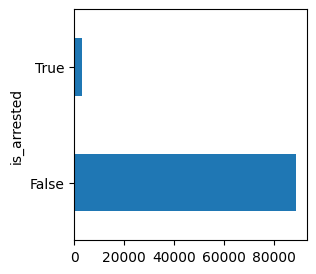

In [20]:
y.value_counts().plot(kind="barh", figsize=(3, 3))

Decidindo Teste Estatístico de Significância:

1. Distribuição Não Normal (Não Paramétrico) - Bernoulli
2. Pareada: Mesmos dados, vistos por diferentes métricas: Falso Positivo, Falso Negativo, Verdadeiro Positivo, Verdadeiro Negativo
3. 2 Grupos: Bernoulli Naive Bayes e Árvore de Decisão

Portanto, o teste escolhido será o `Wilcoxon`

In [16]:
# calculate p-value with wilcoxon test
from scipy.stats import wilcoxon

result_wilcoxon = wilcoxon(
    matriz_confusao_arvore_decisao.ravel(), matriz_confusao_naive_bayes.ravel()
)

# print p-value
print(f"p-value: {result_wilcoxon.pvalue}")
# print wilcoxon test statistic
print(f"statistic: {result_wilcoxon.statistic}")

# should reject null hypothesis
print(f"Devemos rejeitar a hipótese nula? {result_wilcoxon.pvalue > result_wilcoxon.statistic}")

p-value: 1.0
statistic: 5.0
Devemos rejeitar a hipótese nula? False


Não rejeitamos a hipótese nula *H0*, ou seja, não há diferença significativa entre os modelos.